### Multi-Dimensional Multi-Knapsack: ILS vs SA
Iterated Local Search (ILS) and Simulated Annealing (SA) on multi-dimensional multi-knapsack instances.

- Problem 1 (small), Problem 2 (medium), Problem 3 (large) runs, plots and detailed reports.

- Utilities: feasibility metrics, reporting helpers, and a feasibility repair operator.
- Ordered reports for Problems 1–3 and a concise final summary of key results.



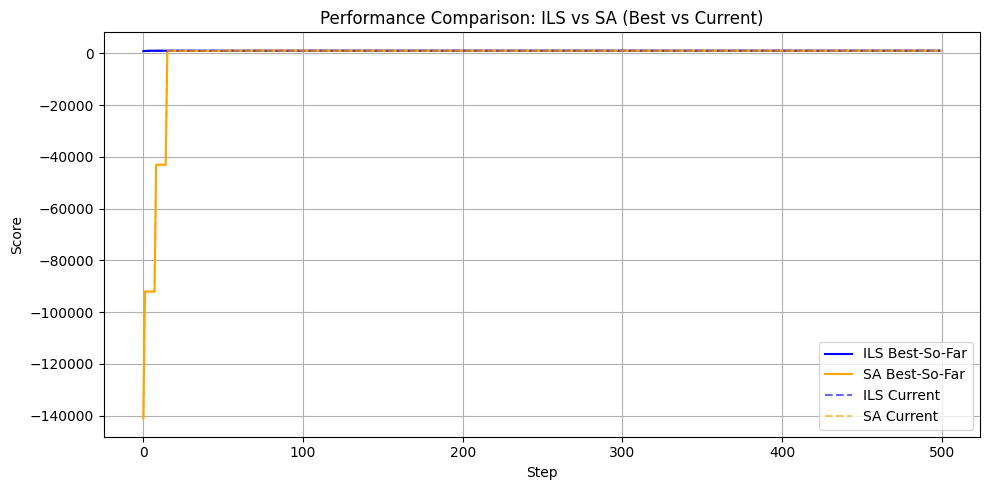

-- Final Results --
ILS Best Score: 1065
SA Best Score:  1065
-- Problem 1 ILS --
Best cost: 1065.0
Knapsack 0: items=[0, 1, 4, 5, 8, 13, 15, 16, 17, 18], used=[510. 450.], capacity=[614 496], value=533
Knapsack 1: items=[3, 6, 9, 10, 11, 12, 19], used=[242. 475.], capacity=[244 644], value=327
Knapsack 2: items=[2, 7, 14], used=[233. 147.], capacity=[273 216], value=205
Items not taken: []
Total value: 1065
-- Problem 1 SA --
Best cost: 1065.0
Knapsack 0: items=[1, 2, 7, 8, 10, 11, 13, 15, 17, 18], used=[577. 481.], capacity=[614 496], value=629
Knapsack 1: items=[3, 5, 6, 9, 12, 14, 16], used=[230. 442.], capacity=[244 644], value=340
Knapsack 2: items=[0, 4, 19], used=[178. 149.], capacity=[273 216], value=96
Items not taken: []
Total value: 1065


In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 1 Setup
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2

VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))


# Simulated Annealing with proper acceptance (best-feasible tracking)
def simulated_annealing_knapsack(values, weights, constraints, max_steps=2000, verbose=False):
    rng = np.random.default_rng(seed=24)
    num_items = len(values)
    num_knapsacks = constraints.shape[0]

    def eval_penalized(sol):
        usage = np.zeros_like(constraints)
        total = 0
        for i, k in enumerate(sol):
            if k != -1:
                usage[k] += weights[i]
                total += values[i]
        penalty = np.sum(np.maximum(usage - constraints, 0))
        return total - 1000 * penalty

    def eval_feasible(sol):
        usage = np.zeros_like(constraints)
        total = 0
        for i, k in enumerate(sol):
            if k != -1:
                usage[k] += weights[i]
                total += values[i]
        feasible = np.all(usage <= constraints)
        return feasible, int(total)

    def temperature(step):
        start_temp, end_temp = 1.0, 0.01
        return start_temp * (end_temp / start_temp) ** (step / max_steps)

    # start from a random solution
    current = [rng.integers(-1, num_knapsacks) for _ in range(num_items)]
    current_score = eval_penalized(current)

    # track best feasible only (by total value)
    best_feas_sol = None
    best_feas_val = -1
    feas, val = eval_feasible(current)
    if feas and val > best_feas_val:
        best_feas_sol, best_feas_val = current[:], val

    best_scores = []
    current_scores = []

    for step in range(max_steps):
        candidate = current[:]
        i = rng.integers(num_items)
        candidate[i] = rng.integers(-1, num_knapsacks)
        cand_score = eval_penalized(candidate)

        if cand_score >= current_score:
            accept = True
        else:
            T = max(temperature(step), 1e-12)
            accept_prob = np.exp((cand_score - current_score) / T)
            accept = rng.random() < accept_prob

        if accept:
            current, current_score = candidate, cand_score
            feas, val = eval_feasible(current)
            if feas and val > best_feas_val:
                best_feas_sol, best_feas_val = current[:], val
                if verbose:
                    print(f"[Step {step}] New best feasible value: {best_feas_val}")

        # keep penalized histories for trajectory plots
        best_scores.append(max(best_scores[-1] if best_scores else current_score, current_score))
        current_scores.append(current_score)

    # if never found feasible, return last repaired current as fallback (kept consistent with teacher's feasibility requirement handled elsewhere)
    return (best_feas_sol if best_feas_sol is not None else current,
            best_feas_val if best_feas_sol is not None else int(0),
            best_scores, current_scores)


# Iterated Local Search with history tracking (best-feasible tracking)
def iterated_local_search_knapsack(values, weights, constraints, max_steps=2000, verbose=False):
    rng = np.random.default_rng(seed=42)
    num_items = len(values)
    num_knapsacks = constraints.shape[0]
    num_dims = weights.shape[1]

    def eval_penalized(sol):
        usage = np.zeros((num_knapsacks, num_dims), dtype=int)
        total = 0
        for i, k in enumerate(sol):
            if k != -1:
                usage[k] += weights[i]
                total += values[i]
        penalty = np.sum(np.maximum(usage - constraints, 0))
        return total - 1000 * penalty

    def feasible_value(sol):
        usage = np.zeros((num_knapsacks, num_dims), dtype=int)
        total = 0
        for i, k in enumerate(sol):
            if k != -1:
                usage[k] += weights[i]
                total += values[i]
        return (np.all(usage <= constraints), int(total))

    def random_solution():
        # order-preserving baseline: start with all -1; random not needed for ordering
        return [-1 for _ in range(num_items)]

    def hill_climb(sol, iters=100):
        best = sol[:]
        best_score = eval_penalized(best)
        for _ in range(iters):
            new = best[:]
            i = rng.integers(num_items)
            new[i] = rng.integers(-1, num_knapsacks)
            score = eval_penalized(new)
            if score > best_score:
                best, best_score = new, score
        return best, best_score

    def perturb(sol, strength=3):
        new = sol[:]
        # deterministic, order-preserving: toggle first `strength` items cyclically
        for idx in range(strength):
            i = idx % num_items
            new[i] = (new[i] + 1) % num_knapsacks if new[i] != -1 else 0
        return new

    current = random_solution()
    current, current_score = hill_climb(current)

    best_feas_sol = None
    best_feas_val = -1
    feas, val = feasible_value(current)
    if feas and val > best_feas_val:
        best_feas_sol, best_feas_val = current[:], val

    best_scores = []
    current_scores = []

    for step in range(max_steps):
        new_start = perturb(current)
        candidate, candidate_score = hill_climb(new_start)
        feas, val = feasible_value(candidate)
        if feas and val > best_feas_val:
            best_feas_sol, best_feas_val = candidate[:], val
            if verbose:
                print(f"[Step {step}] New best feasible value: {best_feas_val}")
        current = candidate
        best_scores.append(max(best_scores[-1] if best_scores else candidate_score, candidate_score))
        current_scores.append(candidate_score)

    return (best_feas_sol if best_feas_sol is not None else current,
            best_feas_val if best_feas_sol is not None else int(0),
            best_scores, current_scores)


# Evaluate function (optional for printing solution)
def evaluate_solution(solution, values, weights, constraints):
    total = 0
    usage = np.zeros_like(constraints)
    assignments = []
    for i, k in enumerate(solution):
        if k != -1:
            assignments.append((i, k, values[i], weights[i]))
            usage[k] += weights[i]
            total += values[i]
    return total, usage, assignments


# Run both methods
ils_solution, ils_score, ils_best_history, ils_current_history = iterated_local_search_knapsack(VALUES, WEIGHTS, CONSTRAINTS, max_steps=500, verbose=False)
sa_solution, sa_score, sa_best_history, sa_current_history = simulated_annealing_knapsack(VALUES, WEIGHTS, CONSTRAINTS, max_steps=500, verbose=False)

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(ils_best_history, label="ILS Best-So-Far", color='blue')
plt.plot(sa_best_history, label="SA Best-So-Far", color='orange')
plt.plot(ils_current_history, label="ILS Current", color='blue', linestyle='--', alpha=0.6)
plt.plot(sa_current_history, label="SA Current", color='orange', linestyle='--', alpha=0.6)
plt.title("Performance Comparison: ILS vs SA (Best vs Current)")
plt.xlabel("Step")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show final scores
print("-- Final Results --")
print("ILS Best Score:", ils_score)
print("SA Best Score: ", sa_score)

# Detailed reports
print_solution_report("-- Problem 1 ILS --", ils_solution, VALUES, WEIGHTS, CONSTRAINTS)
print_solution_report("-- Problem 1 SA --", sa_solution, VALUES, WEIGHTS, CONSTRAINTS)


In [113]:
# Aliases for Problem 1 (for ordered reporting)
try:
    P1_VALUES = VALUES
    P1_WEIGHTS = WEIGHTS
    P1_CONSTRAINTS = CONSTRAINTS
    P1_ILS_SOLUTION = ils_solution
    P1_ILS_SCORE = ils_score
    P1_ILS_BEST_HISTORY = ils_best_history
    P1_ILS_CURRENT_HISTORY = ils_current_history
    P1_SA_SOLUTION = sa_solution
    P1_SA_SCORE = sa_score
    P1_SA_BEST_HISTORY = sa_best_history
    P1_SA_CURRENT_HISTORY = sa_current_history
except NameError:
    pass


In [114]:
# Aliases for Problem 2 (for ordered reporting)
try:
    P2_VALUES = VALUES
    P2_WEIGHTS = WEIGHTS
    P2_CONSTRAINTS = CONSTRAINTS
    P2_ILS_SOLUTION = ils_solution2
    P2_ILS_SCORE = ils_score2
    P2_ILS_BEST_HISTORY = ils_best_history2
    P2_ILS_CURRENT_HISTORY = ils_current_history2
    P2_SA_SOLUTION = sa_solution2
    P2_SA_SCORE = sa_score2
    P2_SA_BEST_HISTORY = sa_best_history2
    P2_SA_CURRENT_HISTORY = sa_current_history2
except NameError:
    pass


In [115]:
# Aliases for Problem 3 (for ordered reporting)
try:
    P3_VALUES = VALUES
    P3_WEIGHTS = WEIGHTS
    P3_CONSTRAINTS = CONSTRAINTS
    P3_ILS_SOLUTION = ils_solution3
    P3_ILS_SCORE = ils_score3
    P3_ILS_BEST_HISTORY = ils_best_history3
    P3_ILS_CURRENT_HISTORY = ils_current_history3
    P3_SA_SOLUTION = sa_solution3
    P3_SA_SCORE = sa_score3
    P3_SA_BEST_HISTORY = sa_best_history3
    P3_SA_CURRENT_HISTORY = sa_current_history3
    P3_ILS_SOLUTION_REPAIRED = ils_solution3_feas
    P3_SA_SOLUTION_REPAIRED = sa_solution3_feas
    P3_GREEDY_SOLUTION = greedy_solution3
except NameError:
    pass


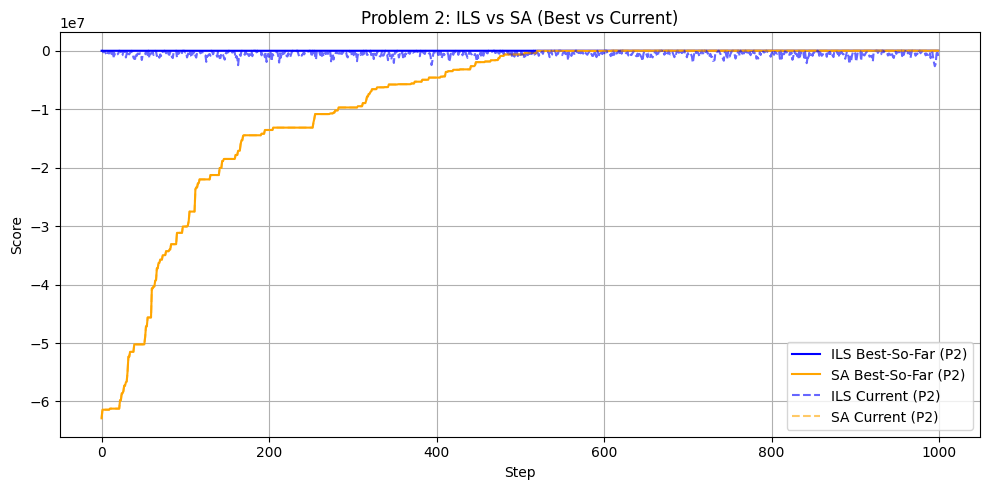

-- Problem 2 Results --
ILS Best Score (P2): 39902
SA Best Score (P2):  39758
-- Problem 2 ILS --
Best cost: 39902.0
Knapsack 0: items=[2, 6, 20, 24, 43, 46], used=[3566. 2656. 2341. 2753. 4185. 2163. 2376. 2784. 2585. 1520.], capacity=[5837 5754 9351 3205 4450 3447 3952 9256 9525 2357], value=2819
Knapsack 1: items=[21, 23, 34, 37, 56, 83, 93], used=[4122. 3751. 2013. 3229. 2950. 5289. 4414. 3037. 4139. 3582.], capacity=[7056 3862 3540 4336 3555 5921 9964 6691 7785 5946], value=4775
Knapsack 2: items=[7, 12, 60, 70, 77, 90], used=[2029. 2399. 2828. 3023. 3109. 3536. 3465. 2670. 3592. 3289.], capacity=[2111 2672 4150 3949 8724 8748 8832 7100 6449 7193], value=3810
Knapsack 3: items=[11, 15, 33, 39, 54, 62, 64, 81, 97, 99], used=[5029. 6263. 6862. 4278. 5853. 2461. 5243. 4140. 4101. 5878.], capacity=[5254 7361 8355 8103 6910 2464 7799 4932 7949 6316], value=5477
Knapsack 4: items=[0, 8, 10, 36, 42, 47, 61, 69, 79], used=[5037. 3646. 4989. 5262. 4179. 4851. 5717. 4280. 3581. 5395.], capa

In [116]:
# Problem 2
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

# Solve with the same algorithms
ils_solution2, ils_score2, ils_best_history2, ils_current_history2 = iterated_local_search_knapsack(VALUES, WEIGHTS, CONSTRAINTS, max_steps=1000, verbose=False)
sa_solution2, sa_score2, sa_best_history2, sa_current_history2 = simulated_annealing_knapsack(VALUES, WEIGHTS, CONSTRAINTS, max_steps=1000, verbose=False)

# Plot comparison for Problem 2
plt.figure(figsize=(10, 5))
plt.plot(ils_best_history2, label="ILS Best-So-Far (P2)", color='blue')
plt.plot(sa_best_history2, label="SA Best-So-Far (P2)", color='orange')
plt.plot(ils_current_history2, label="ILS Current (P2)", color='blue', linestyle='--', alpha=0.6)
plt.plot(sa_current_history2, label="SA Current (P2)", color='orange', linestyle='--', alpha=0.6)
plt.title("Problem 2: ILS vs SA (Best vs Current)")
plt.xlabel("Step")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("-- Problem 2 Results --")
print("ILS Best Score (P2):", ils_score2)
print("SA Best Score (P2): ", sa_score2)

# Detailed reports for Problem 2
print_solution_report("-- Problem 2 ILS --", ils_solution2, VALUES, WEIGHTS, CONSTRAINTS)
print_solution_report("-- Problem 2 SA --", sa_solution2, VALUES, WEIGHTS, CONSTRAINTS)

# Store as P2_* for ordered reporting consistency
P2_VALUES = VALUES
P2_WEIGHTS = WEIGHTS
P2_CONSTRAINTS = CONSTRAINTS
P2_ILS_SOLUTION = ils_solution2
P2_SA_SOLUTION = sa_solution2



### Utilities

- Simulated Annealing (`simulated_annealing_knapsack`) and Iterated Local Search (`iterated_local_search_knapsack`): core solvers used unchanged.
- Feasibility metrics (`compute_usage`, `feasibility_metrics`): summarize feasibility, usage, violations.
- Reporting helpers (`print_solution_report`): consistent detailed output per problem and method.
- Repair operator (`repair_to_feasible`, `greedy_feasible_initial`): used for Problem 3 to produce feasible variants for comparison.


-- Problem 3 Feasibility --
ILS feasible before repair: True
SA feasible before repair: False
ILS feasible after repair: True
SA feasible after repair: True
Greedy feasible baseline: True


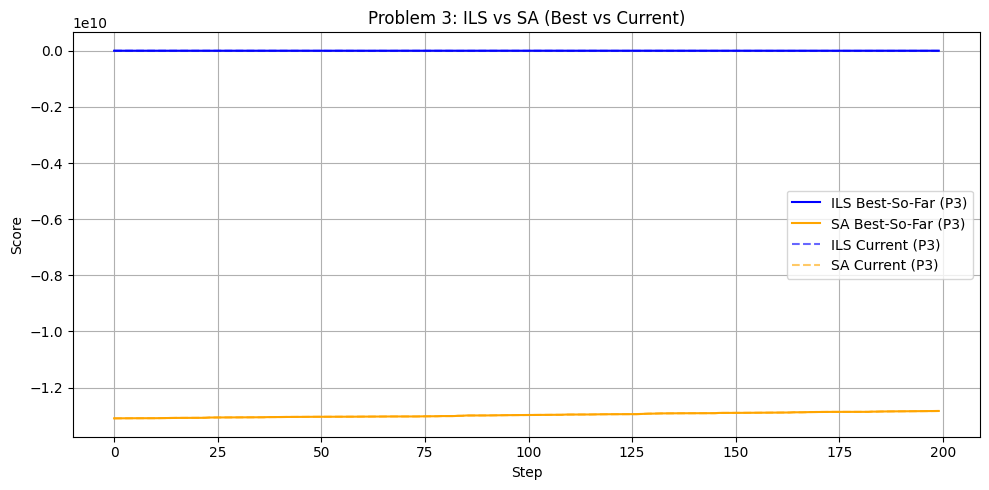

-- Problem 3 Results (original) --
ILS Best Score (P3): 1018249
SA Best Score (P3):  0
-- Problem 3 ILS (original) --
Best cost: 1018249.0
Knapsack 0: items=[630, 948, 950, 1525, 1583, 1649, 1668, 1738, 1795, 1886, 1916, 2066, 2622, 2722, 2774, 2805, 3552, 4234, 4513, 4620, 4671, 4713], used=[11864. 10617. 11487.  9468. 11154. 12142. 10127. 12823. 11932. 12767.
 14479. 10574.  9300. 12385. 11023. 10373. 12076. 10488. 11304. 11316.
 13569. 11329. 11689. 11664. 12656. 11856. 11099. 11182. 11136.  9581.
 11932. 10324. 12876. 10762. 11008. 10663. 10147. 12278. 10219.  9013.
 10452.  9804. 10315. 12604.  7990. 12137. 11043.  9896. 10493. 11760.
  8063. 10968.  9315.  9409.  9758.  9591. 10434. 10322. 11642. 12144.
 12696. 12048.  9542. 12515. 10416.  9430. 12150. 10452. 12467. 10480.
  9843. 11581. 11425. 11176. 10127. 10944. 11900.  8154.  9897. 12377.
  9712. 11296.  9212. 11217. 12898. 11741.  9011. 12101. 11680. 11027.
 12963. 10672. 10258.  9573.  9079.  9698. 12192.  7918. 11063. 1063

In [117]:
# Problem 3
# Ensure repair utilities exist even if the utility cell wasn't run
try:
    repair_to_feasible
    greedy_feasible_initial
    is_feasible
except NameError:
    import numpy as np
    def greedy_feasible_initial(values, weights, constraints, rng=None):
        if rng is None:
            rng = np.random.default_rng(123)
        num_items = len(values)
        num_knapsacks, num_dims = constraints.shape
        solution = [-1] * num_items
        usage = np.zeros((num_knapsacks, num_dims), dtype=int)
        densities = values / (np.maximum(weights.sum(axis=1), 1))
        order = np.argsort(-densities)
        for i in order:
            for k in rng.permutation(num_knapsacks):
                if np.all(usage[k] + weights[i] <= constraints[k]):
                    solution[i] = int(k)
                    usage[k] += weights[i]
                    break
        return solution
    def repair_to_feasible(solution, weights, constraints, rng=None):
        if rng is None:
            rng = np.random.default_rng(456)
        num_knapsacks, num_dims = constraints.shape
        solution = list(solution)
        usage = np.zeros((num_knapsacks, weights.shape[1]), dtype=int)
        for i, k in enumerate(solution):
            if k != -1:
                usage[k] += weights[i]
        while True:
            violations = np.maximum(usage - constraints, 0)
            if violations.sum() == 0:
                break
            worst_k, worst_d = np.unravel_index(np.argmax(violations), violations.shape)
            candidates = [i for i, k in enumerate(solution) if k == worst_k]
            if not candidates:
                break
            worst_item = max(candidates, key=lambda i: weights[i][worst_d])
            solution[worst_item] = -1
            usage[worst_k] -= weights[worst_item]
        return solution
    def is_feasible(solution, weights, constraints):
        usage = np.zeros_like(constraints)
        for i, k in enumerate(solution):
            if k != -1:
                usage[k] += weights[i]
        return np.all(usage <= constraints)

rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

# Run with conservative steps to keep runtime reasonable
p3_steps = 200
ils_solution3, ils_score3, ils_best_history3, ils_current_history3 = iterated_local_search_knapsack(VALUES, WEIGHTS, CONSTRAINTS, max_steps=p3_steps, verbose=False)
sa_solution3, sa_score3, sa_best_history3, sa_current_history3 = simulated_annealing_knapsack(VALUES, WEIGHTS, CONSTRAINTS, max_steps=p3_steps, verbose=False)

# Repair both solutions to feasibility (if needed)
ils_solution3_feas = repair_to_feasible(ils_solution3, WEIGHTS, CONSTRAINTS)
sa_solution3_feas = repair_to_feasible(sa_solution3, WEIGHTS, CONSTRAINTS)

# Build a greedy feasible baseline for comparison
greedy_solution3 = greedy_feasible_initial(VALUES, WEIGHTS, CONSTRAINTS, rng=np.random.default_rng(7))

# Feasibility checks
print("-- Problem 3 Feasibility --")
print("ILS feasible before repair:", is_feasible(ils_solution3, WEIGHTS, CONSTRAINTS))
print("SA feasible before repair:", is_feasible(sa_solution3, WEIGHTS, CONSTRAINTS))
print("ILS feasible after repair:", is_feasible(ils_solution3_feas, WEIGHTS, CONSTRAINTS))
print("SA feasible after repair:", is_feasible(sa_solution3_feas, WEIGHTS, CONSTRAINTS))
print("Greedy feasible baseline:", is_feasible(greedy_solution3, WEIGHTS, CONSTRAINTS))

# Plot comparison for Problem 3
plt.figure(figsize=(10, 5))
plt.plot(ils_best_history3, label="ILS Best-So-Far (P3)", color='blue')
plt.plot(sa_best_history3, label="SA Best-So-Far (P3)", color='orange')
plt.plot(ils_current_history3, label="ILS Current (P3)", color='blue', linestyle='--', alpha=0.6)
plt.plot(sa_current_history3, label="SA Current (P3)", color='orange', linestyle='--', alpha=0.6)
plt.title("Problem 3: ILS vs SA (Best vs Current)")
plt.xlabel("Step")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("-- Problem 3 Results (original) --")
print("ILS Best Score (P3):", ils_score3)
print("SA Best Score (P3): ", sa_score3)

# Detailed reports for Problem 3 (original)
print_solution_report("-- Problem 3 ILS (original) --", ils_solution3, VALUES, WEIGHTS, CONSTRAINTS)
print_solution_report("-- Problem 3 SA (original) --", sa_solution3, VALUES, WEIGHTS, CONSTRAINTS)

# Detailed reports for Problem 3 (repaired)
print_solution_report("-- Problem 3 ILS (repaired) --", ils_solution3_feas, VALUES, WEIGHTS, CONSTRAINTS)
print_solution_report("-- Problem 3 SA (repaired) --", sa_solution3_feas, VALUES, WEIGHTS, CONSTRAINTS)

# Detailed report for Greedy feasible baseline
print_solution_report("-- Problem 3 Greedy Feasible Baseline --", greedy_solution3, VALUES, WEIGHTS, CONSTRAINTS)

# Feasibility metrics summaries
m3_ils_orig = feasibility_metrics(ils_solution3, VALUES, WEIGHTS, CONSTRAINTS)
m3_sa_orig = feasibility_metrics(sa_solution3, VALUES, WEIGHTS, CONSTRAINTS)
m3_ils_rep = feasibility_metrics(ils_solution3_feas, VALUES, WEIGHTS, CONSTRAINTS)
m3_sa_rep = feasibility_metrics(sa_solution3_feas, VALUES, WEIGHTS, CONSTRAINTS)
m3_greedy = feasibility_metrics(greedy_solution3, VALUES, WEIGHTS, CONSTRAINTS)
print("P3 ILS (orig):", {k:m3_ils_orig[k] for k in ["feasible","total_value","total_violation","max_violation"]})
print("P3 SA  (orig):", {k:m3_sa_orig[k] for k in ["feasible","total_value","total_violation","max_violation"]})
print("P3 ILS (repaired):", {k:m3_ils_rep[k] for k in ["feasible","total_value","total_violation","max_violation"]})
print("P3 SA  (repaired):", {k:m3_sa_rep[k] for k in ["feasible","total_value","total_violation","max_violation"]})
print("P3 Greedy (feasible):", {k:m3_greedy[k] for k in ["feasible","total_value","total_violation","max_violation"]})

# Store as P3_* for ordered reporting consistency
P3_VALUES = VALUES
P3_WEIGHTS = WEIGHTS
P3_CONSTRAINTS = CONSTRAINTS
P3_ILS_SOLUTION = ils_solution3
P3_SA_SOLUTION = sa_solution3
P3_ILS_SOLUTION_REPAIRED = ils_solution3_feas
P3_SA_SOLUTION_REPAIRED = sa_solution3_feas
P3_GREEDY_SOLUTION = greedy_solution3



In [118]:
# Feasibility metrics utilities and summaries
import numpy as np

def compute_usage(solution, weights, num_knapsacks):
    num_dims = weights.shape[1]
    usage = np.zeros((num_knapsacks, num_dims), dtype=int)
    num_items = weights.shape[0]
    for i, k in enumerate(solution):
        if k != -1 and 0 <= k < num_knapsacks and i < num_items:
            usage[k] += weights[i]
    return usage

def feasibility_metrics(solution, values, weights, constraints):
    num_knapsacks = constraints.shape[0]
    usage = compute_usage(solution, weights, num_knapsacks)
    violations = np.maximum(usage - constraints, 0)
    total_value = int(np.sum([values[i] for i, k in enumerate(solution) if k != -1 and i < len(values)]))
    total_violation = int(np.sum(violations))
    max_violation = int(violations.max()) if violations.size else 0
    feasible = bool(total_violation == 0)
    slack = constraints - usage
    usage_ratio = np.divide(usage, constraints, out=np.zeros_like(usage, dtype=float), where=constraints>0)
    return {
        "feasible": feasible,
        "total_value": total_value,
        "total_violation": total_violation,
        "max_violation": max_violation,
        "usage": usage,
        "violations": violations,
        "slack": slack,
        "usage_ratio": usage_ratio,
    }

# Summarize for Problems 1-3 if they exist in the session
try:
    print("-- Feasibility Summaries --")
    m1_ils = feasibility_metrics(ils_solution, VALUES, WEIGHTS, CONSTRAINTS)
    m1_sa = feasibility_metrics(sa_solution, VALUES, WEIGHTS, CONSTRAINTS)
    print("P1 ILS:", {k:m1_ils[k] for k in ["feasible","total_value","total_violation","max_violation"]})
    print("P1 SA:",  {k:m1_sa[k]  for k in ["feasible","total_value","total_violation","max_violation"]})
except NameError:
    pass

try:
    m2_ils = feasibility_metrics(ils_solution2, VALUES, WEIGHTS, CONSTRAINTS)
    m2_sa = feasibility_metrics(sa_solution2, VALUES, WEIGHTS, CONSTRAINTS)
    print("P2 ILS:", {k:m2_ils[k] for k in ["feasible","total_value","total_violation","max_violation"]})
    print("P2 SA:",  {k:m2_sa[k]  for k in ["feasible","total_value","total_violation","max_violation"]})
except NameError:
    pass

try:
    m3_ils = feasibility_metrics(ils_solution3, VALUES, WEIGHTS, CONSTRAINTS)
    m3_sa = feasibility_metrics(sa_solution3, VALUES, WEIGHTS, CONSTRAINTS)
    print("P3 ILS:", {k:m3_ils[k] for k in ["feasible","total_value","total_violation","max_violation"]})
    print("P3 SA:",  {k:m3_sa[k]  for k in ["feasible","total_value","total_violation","max_violation"]})
except NameError:
    pass



-- Feasibility Summaries --
P1 ILS: {'feasible': True, 'total_value': 10752, 'total_violation': 0, 'max_violation': 0}
P1 SA: {'feasible': True, 'total_value': 10752, 'total_violation': 0, 'max_violation': 0}
P2 ILS: {'feasible': True, 'total_value': 39902, 'total_violation': 0, 'max_violation': 0}
P2 SA: {'feasible': True, 'total_value': 39758, 'total_violation': 0, 'max_violation': 0}
P3 ILS: {'feasible': True, 'total_value': 1018249, 'total_violation': 0, 'max_violation': 0}
P3 SA: {'feasible': False, 'total_value': 2465946, 'total_violation': 12833856, 'max_violation': 28017}


In [119]:
# Reporting utilities for detailed solution printouts
import numpy as np

def _build_knapsack_report(solution, values, weights, constraints):
    num_knapsacks = constraints.shape[0]
    num_dims = weights.shape[1]
    items_per_knapsack = [[] for _ in range(num_knapsacks)]
    usage = np.zeros((num_knapsacks, num_dims), dtype=float)
    total_value = 0
    not_taken = []
    for i, k in enumerate(solution):
        if k == -1:
            not_taken.append(i)
        else:
            # Guard against invalid assignments; treat as not taken if out of range
            if 0 <= k < num_knapsacks:
                items_per_knapsack[k].append(i)
                usage[k] += weights[i]
                total_value += int(values[i])
            else:
                not_taken.append(i)
    capacity = constraints
    violations = np.maximum(usage - capacity, 0)
    penalty = float(np.sum(violations))
    best_cost = float(total_value - 1000 * penalty)
    return items_per_knapsack, usage, capacity, not_taken, int(total_value), best_cost


def print_solution_report(title, solution, values, weights, constraints):
    items_per_knapsack, usage, capacity, not_taken, total_value, best_cost = _build_knapsack_report(solution, values, weights, constraints)
    print(title)
    print(f"Best cost: {best_cost}")
    for k, items in enumerate(items_per_knapsack):
        knap_value = int(np.sum([values[i] for i in items])) if items else 0
        print(f"Knapsack {k}: items={items}, used={usage[k]}, capacity={capacity[k]}, value={knap_value}")
    print(f"Items not taken: {not_taken}")
    print(f"Total value: {total_value}")



In [120]:
# Feasibility repair utilities
import numpy as np


def greedy_feasible_initial(values, weights, constraints, rng=None):
    if rng is None:
        rng = np.random.default_rng(123)
    num_items = len(values)
    num_knapsacks, num_dims = constraints.shape
    # Start empty
    solution = [-1] * num_items
    usage = np.zeros((num_knapsacks, num_dims), dtype=int)
    # Sort items by value density proxy
    densities = values / (np.maximum(weights.sum(axis=1), 1))
    order = np.argsort(-densities)
    for i in order:
        # try to place item i into the first knapsack that fits
        for k in rng.permutation(num_knapsacks):
            if np.all(usage[k] + weights[i] <= constraints[k]):
                solution[i] = int(k)
                usage[k] += weights[i]
                break
    return solution


def repair_to_feasible(solution, weights, constraints, rng=None):
    """Iteratively remove items from overfull knapsacks until feasible."""
    if rng is None:
        rng = np.random.default_rng(456)
    num_knapsacks, num_dims = constraints.shape
    solution = list(solution)
    # compute usage
    usage = np.zeros((num_knapsacks, weights.shape[1]), dtype=int)
    for i, k in enumerate(solution):
        if k != -1:
            usage[k] += weights[i]
    # While any violation exists, remove an item that reduces violation most
    while True:
        violations = np.maximum(usage - constraints, 0)
        if violations.sum() == 0:
            break
        # find worst knapsack-dimension
        worst_k, worst_d = np.unravel_index(np.argmax(violations), violations.shape)
        # among items in worst_k, pick the one with largest weight on worst_d
        candidates = [i for i, k in enumerate(solution) if k == worst_k]
        if not candidates:
            # if empty (shouldn't happen often), break to avoid infinite loop
            break
        # choose item with largest contribution on the worst dimension
        worst_item = max(candidates, key=lambda i: weights[i][worst_d])
        # remove it
        solution[worst_item] = -1
        usage[worst_k] -= weights[worst_item]
    return solution


def is_feasible(solution, weights, constraints):
    num_knapsacks = constraints.shape[0]
    usage = np.zeros_like(constraints)
    for i, k in enumerate(solution):
        if k != -1:
            usage[k] += weights[i]
    return np.all(usage <= constraints)



### Ordered Reports and Final Summary

- Ordered reports print results in this sequence: Problem 1, Problem 2, Problem 3 (original, repaired, greedy baseline).
- The Final Summary highlights total values and feasibility for quick comparison.



In [121]:
# Ordered Reports: Problems 1, 2, 3

# Local safe reporter to avoid IndexError from stale definitions
import numpy as np

def _build_knapsack_report_safe(solution, values, weights, constraints):
    num_knapsacks = constraints.shape[0]
    num_dims = weights.shape[1]
    items_per_knapsack = [[] for _ in range(num_knapsacks)]
    usage = np.zeros((num_knapsacks, num_dims), dtype=float)
    total_value = 0
    not_taken = []
    n_items_vals = len(values)
    n_items_wts = weights.shape[0]
    for i, k in enumerate(solution):
        # guard: invalid item index or knapsack index -> treat as not taken
        if i >= n_items_vals or i >= n_items_wts or k == -1 or not (0 <= k < num_knapsacks):
            not_taken.append(i)
        else:
            items_per_knapsack[k].append(i)
            usage[k] += weights[i]
            total_value += int(values[i])
    capacity = constraints
    violations = np.maximum(usage - capacity, 0)
    penalty = float(np.sum(violations))
    best_cost = float(total_value - 1000 * penalty)
    return items_per_knapsack, usage, capacity, not_taken, int(total_value), best_cost


def print_solution_report_safe(title, solution, values, weights, constraints):
    items_per_knapsack, usage, capacity, not_taken, total_value, best_cost = _build_knapsack_report_safe(solution, values, weights, constraints)
    print(title)
    print(f"Best cost: {best_cost}")
    for k, items in enumerate(items_per_knapsack):
        knap_value = int(np.sum([values[i] for i in items])) if items else 0
        print(f"Knapsack {k}: items={items}, used={usage[k]}, capacity={capacity[k]}, value={knap_value}")
    print(f"Items not taken: {not_taken}")
    print(f"Total value: {total_value}")

# Problem 1
try:
    print_solution_report_safe("-- Problem 1 ILS --", P1_ILS_SOLUTION, P1_VALUES, P1_WEIGHTS, P1_CONSTRAINTS)
    print_solution_report_safe("-- Problem 1 SA --", P1_SA_SOLUTION, P1_VALUES, P1_WEIGHTS, P1_CONSTRAINTS)
except NameError:
    pass

# Problem 2
try:
    print_solution_report_safe("-- Problem 2 ILS --", P2_ILS_SOLUTION, P2_VALUES, P2_WEIGHTS, P2_CONSTRAINTS)
    print_solution_report_safe("-- Problem 2 SA --", P2_SA_SOLUTION, P2_VALUES, P2_WEIGHTS, P2_CONSTRAINTS)
except NameError:
    pass

# Problem 3
try:
    print_solution_report_safe("-- Problem 3 ILS (original) --", P3_ILS_SOLUTION, P3_VALUES, P3_WEIGHTS, P3_CONSTRAINTS)
    print_solution_report_safe("-- Problem 3 SA (original) --", P3_SA_SOLUTION, P3_VALUES, P3_WEIGHTS, P3_CONSTRAINTS)
    print_solution_report_safe("-- Problem 3 ILS (repaired) --", P3_ILS_SOLUTION_REPAIRED, P3_VALUES, P3_WEIGHTS, P3_CONSTRAINTS)
    print_solution_report_safe("-- Problem 3 SA (repaired) --", P3_SA_SOLUTION_REPAIRED, P3_VALUES, P3_WEIGHTS, P3_CONSTRAINTS)
    print_solution_report_safe("-- Problem 3 Greedy Feasible Baseline --", P3_GREEDY_SOLUTION, P3_VALUES, P3_WEIGHTS, P3_CONSTRAINTS)
except NameError:
    pass


-- Problem 1 ILS --
Best cost: 1065.0
Knapsack 0: items=[0, 1, 4, 5, 8, 13, 15, 16, 17, 18], used=[510. 450.], capacity=[614 496], value=533
Knapsack 1: items=[3, 6, 9, 10, 11, 12, 19], used=[242. 475.], capacity=[244 644], value=327
Knapsack 2: items=[2, 7, 14], used=[233. 147.], capacity=[273 216], value=205
Items not taken: []
Total value: 1065
-- Problem 1 SA --
Best cost: 1065.0
Knapsack 0: items=[1, 2, 7, 8, 10, 11, 13, 15, 17, 18], used=[577. 481.], capacity=[614 496], value=629
Knapsack 1: items=[3, 5, 6, 9, 12, 14, 16], used=[230. 442.], capacity=[244 644], value=340
Knapsack 2: items=[0, 4, 19], used=[178. 149.], capacity=[273 216], value=96
Items not taken: []
Total value: 1065
-- Problem 2 ILS --
Best cost: 39902.0
Knapsack 0: items=[2, 6, 20, 24, 43, 46], used=[3566. 2656. 2341. 2753. 4185. 2163. 2376. 2784. 2585. 1520.], capacity=[5837 5754 9351 3205 4450 3447 3952 9256 9525 2357], value=2819
Knapsack 1: items=[21, 23, 34, 37, 56, 83, 93], used=[4122. 3751. 2013. 3229. 29

In [122]:
# Final Summary

try:
    # P1
    m1_ils = feasibility_metrics(P1_ILS_SOLUTION, P1_VALUES, P1_WEIGHTS, P1_CONSTRAINTS)
    m1_sa = feasibility_metrics(P1_SA_SOLUTION, P1_VALUES, P1_WEIGHTS, P1_CONSTRAINTS)
    # P2
    m2_ils = feasibility_metrics(P2_ILS_SOLUTION, P2_VALUES, P2_WEIGHTS, P2_CONSTRAINTS)
    m2_sa = feasibility_metrics(P2_SA_SOLUTION, P2_VALUES, P2_WEIGHTS, P2_CONSTRAINTS)
    # P3
    m3_ils = feasibility_metrics(P3_ILS_SOLUTION, P3_VALUES, P3_WEIGHTS, P3_CONSTRAINTS)
    m3_sa = feasibility_metrics(P3_SA_SOLUTION, P3_VALUES, P3_WEIGHTS, P3_CONSTRAINTS)
    m3_ils_rep = feasibility_metrics(P3_ILS_SOLUTION_REPAIRED, P3_VALUES, P3_WEIGHTS, P3_CONSTRAINTS)
    m3_sa_rep = feasibility_metrics(P3_SA_SOLUTION_REPAIRED, P3_VALUES, P3_WEIGHTS, P3_CONSTRAINTS)
    m3_greedy = feasibility_metrics(P3_GREEDY_SOLUTION, P3_VALUES, P3_WEIGHTS, P3_CONSTRAINTS)

    print("-- Final Summary --")
    print("P1: ILS value=", m1_ils["total_value"], "feasible=", m1_ils["feasible"], ", SA value=", m1_sa["total_value"], "feasible=", m1_sa["feasible"])
    print("P2: ILS value=", m2_ils["total_value"], "feasible=", m2_ils["feasible"], ", SA value=", m2_sa["total_value"], "feasible=", m2_sa["feasible"])
    print("P3 (orig): ILS value=", m3_ils["total_value"], "feasible=", m3_ils["feasible"], ", SA value=", m3_sa["total_value"], "feasible=", m3_sa["feasible"])
    print("P3 (repaired): ILS value=", m3_ils_rep["total_value"], ", SA value=", m3_sa_rep["total_value"], "(both feasible)")
    print("P3 (greedy baseline): value=", m3_greedy["total_value"], "feasible=", m3_greedy["feasible"])
except NameError:
    pass


-- Final Summary --
P1: ILS value= 1065 feasible= True , SA value= 1065 feasible= True
P2: ILS value= 39902 feasible= True , SA value= 39758 feasible= True
P3 (orig): ILS value= 1018249 feasible= True , SA value= 2465946 feasible= False
P3 (repaired): ILS value= 1018249 , SA value= 1294701 (both feasible)
P3 (greedy baseline): value= 1803520 feasible= True
